## Suggested Solver

**Note: This is only a suggested way of solving the problem. This solution is in no way complete and needs significant improvements, something we hope the competition participants will be able to do.**

**Step 1.** First convert all features into categorical features - this makes modeling easier. To do this, in this worksheet we assign a numeric value to every string. For example ```country_group': {'australia': 0,
  'bangladesh': 1,
  'sri lanka': 2,
  'new zealand': 3,
  'south africa': 4,
  'middle east': 5,
  'india': 6,
  'west indies': 7,
  'pakistan': 8,
  'north america': 9,
  'zimbabwe': 10,
  'uk': 11,
  'europe': 12,
  'east asia': 13}```
  
  Note: This is not the ideal or recommended way to do it. [Read here why and other suggestions](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)

**Step 2.** Create new, more predictive features which may indicate state of the game

**Step 3.** Train a model which uses the given features to predict the probability if a given ball is a wicket. Train a few models to check which one is the best.

**Step 4.** Iteriate over the probability threshold to determine the predicted class? In this problem, given that wicket labels are around 5% of the total dataset, if you use the standard threshold of p=0.5 then, almost every model will have the predicted class "not out" for every ball. And while you will see a high accuracy (~95-96%), your model is not actually predictive.
Ideally, find the right threshold for different formats as well given wicket rates are hugely variant by format and match situation. 

Below is a simple implementation of this model. Suggested improvements could be:
1. Better conversion of non numerical features, eg: use one hot encoding
2. Create better features
3. Use a better training mechanism to predict Y (or more feature engineering before predictions)
4. Use a better method to determine threshold
5. Train separate models for batsmen and bowlers instead of one generic mmodel


In [1]:
import pandas as pd
import numpy as np
import os.path
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen

In [2]:
#### LOAD THE HELPER FUNCTIONS BELOW####
#### IMPORTANT: DONOT change these functions or your final submission will not evaluate correctly###

## This downloads your datafile, Do not change this function
def downloadFile(downloadUrl, dataSetId, instrumentId):
      fileName = '%s.csv' % (instrumentId)
      url = downloadUrl + dataSetId + '/' + fileName

      response = urlopen(url)
      status = response.getcode()
      if status == 200:
          print('Downloading the dataset %s' % (fileName))
          with open(fileName, 'w') as f:
              f.write(response.read().decode('utf8'))
          return True
      else:
          logError('File not found. Please ensure you are working with correct data set Id')
          return False


#### Loading the data

In [3]:
cachedFolderName='historicalData/'
dataSetId='p1'
instrumentIds=['trainingData']
downloadUrl = 'https://qq11-data.s3.amazonaws.com/'
targetVariable = 'Out'
timeKey = 'date'
startDateStr='2010/01/01'
endDateStr='2015/12/31'
if not os.path.isfile('%s.csv' % (instrumentIds[0])):
    downloadFile(downloadUrl, dataSetId, instrumentIds[0])
df = pd.read_csv('%s.csv' % (instrumentIds[0]), index_col=0)

#### Simple data exploration

In [4]:
## Data description
print(df.shape)
print(df.columns)
print(df.dtypes)


(874860, 31)
Index(['batsman_hand', 'batsman_name', 'batsman_number', 'batting_team_name',
       'bowler_hand', 'bowler_name', 'bowler_style', 'bowling_team_name',
       'country_group', 'cumulative_balls_bowled', 'cumulative_balls_faced',
       'cumulative_balls_faced_nf', 'date', 'innings', 'innings_ball_number',
       'innings_over', 'innings_runs_before_ball', 'innings_wickets',
       'match_format', 'match_id', 'match_quality', 'over_ball', 'pplay_group',
       'required_run_rate', 'target', 'toss_choice', 'toss_winner',
       'venue_name', 'chasing', 'PreviousBallOut', 'Out'],
      dtype='object')
batsman_hand                  object
batsman_name                  object
batsman_number                 int64
batting_team_name             object
bowler_hand                   object
bowler_name                   object
bowler_style                  object
bowling_team_name             object
country_group                 object
cumulative_balls_bowled        int64
cumulative_

In [5]:
data = df.copy()

In [6]:
batsmen = data['batsman_name'].unique()
bowler = data['bowler_name'].unique()
batting_team = data['batting_team_name'].unique()
bowler_style = data['bowler_style'].unique()
bowling_team = data['bowling_team_name'].unique()
country = data['country_group'].unique() 
mformat = data['match_format'].unique()
pplay = data['pplay_group'].unique()
venue = data['venue_name'].unique()
# wicket = data['wicket_type'].unique()

In [7]:
print(batsmen)


['Phil Jaques' 'David Warner' 'Usman Khawaja' ... 'Suboth Bhati'
 'Navdeep Saini' 'Sam Heazlett']


In [8]:
data['date'] = pd.to_datetime(data['date'])

### Step 1 convert to categorical variables

In [9]:
## listing non numerical variabels
listf = []
for c in data.columns:
    if data[c].dtype==object:
        print(c, data[c].dtype)
        listf.append(c)

batsman_hand object
batsman_name object
batting_team_name object
bowler_hand object
bowler_name object
bowler_style object
bowling_team_name object
country_group object
pplay_group object
toss_choice object
toss_winner object
venue_name object


In [10]:
from sklearn import preprocessing

feature_dict ={}
for feature in data.columns:
    if data[feature].dtype==object:  
        le = preprocessing.LabelEncoder()
        fs = data[feature].unique()
        f_dict = {}
        le.fit(fs)
        data[feature] = le.transform(data[feature])
        feature_dict[feature] = le

#### Remove any NaNs and separate the target variable

In [11]:
data[data.isnull().any(axis=1)]
data = data.dropna()
del data['date']

In [12]:
# pd.get_dummies(s1)
y = data['Out']
del data['Out']

### Step 2: Add new features

In [13]:
### an interesting feature might be number of runs scored in last 6 balls 
### and number of wickets in last 6 balls to see if there is pressure on the team

data['run_last_6_balls'] = data['innings_runs_before_ball'].rolling(6).sum()
data['run_last_12_balls'] = data['innings_runs_before_ball'].rolling(12).sum()
data['wkt_last_6_balls'] = data['PreviousBallOut'].rolling(6).sum()
data['wkt_last_12_balls'] = data['PreviousBallOut'].rolling(12).sum()

### remeber to set these as 0 start of the game
data['run_last_6_balls'][data['innings_ball_number']<6] = 0
data['run_last_12_balls'][data['innings_ball_number']<12] = data['run_last_6_balls']
data['wkt_last_6_balls'][data['innings_ball_number']<6] = 0
data['wkt_last_12_balls'][data['innings_ball_number']<12] = data['wkt_last_6_balls']
data.fillna(0, inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/si

### Step 3: Create train-test split and train a few models

In [14]:
from sklearn.metrics import confusion_matrix, log_loss, make_scorer
from sklearn.metrics import roc_curve, precision_recall_curve, auc, recall_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
# dividing X, y into train and test data 
# with stratify=True results in consistent class distribution between training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=y, random_state = 10) 

# show the distribution
print('y_train class distribution')
print(y_train.value_counts(normalize=True))
print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
0.0    0.960993
1.0    0.039007
Name: Out, dtype: float64
y_test class distribution
0.0    0.960995
1.0    0.039005
Name: Out, dtype: float64


In [15]:
 # training a DescisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 10).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 

# accuracy on X_test 
accuracy = dtree_model.score(X_test, y_test) 
print(accuracy)

lg = log_loss(y_test, dtree_predictions)
print(lg)

# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions)
cm

0.9608018765217047
1.35385538415043


array([[194153,     41],
       [  7880,      2]])

In [16]:
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 
# from sklearn.neighbors import RadiusNeighborsClassifier
# neigh = RadiusNeighborsClassifier(radius=1.0).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors = 10, weights='distance').fit(X_train, y_train) 
knn_predictions = knn.predict(X_test)  

# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
# accuracy = neigh.score(X_test, y_test) 
print(accuracy)
  
lg = log_loss(y_test, knn_predictions)
print(lg)

# creating a confusion matrix 

cm = confusion_matrix(y_test, knn_predictions)
# neigh_predictions = neigh.predict(X_test)  
# cm = confusion_matrix(y_test, neigh_predictions)
cm

0.9534877966705596
1.606480854225626


array([[192611,   1583],
       [  7816,     66]])

In [17]:
# training a Naive Bayes classifier 
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 
  
# accuracy on X_test 
accuracy = gnb.score(X_test, y_test) 
print(accuracy)

lg = log_loss(y_test, gnb_predictions)
print(lg)
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, gnb_predictions) 
cm

0.9590995467052
1.4126532489621384


array([[193780,    414],
       [  7851,     31]])

In [18]:
# training a Random Forest classifier 
from sklearn.ensemble import RandomForestClassifier
rforest_model = RandomForestClassifier(n_estimators=300, max_depth=8,random_state=0).fit(X_train, y_train) 
rforest_predictions = rforest_model.predict(X_test) 

# accuracy on X_test 
accuracy = rforest_model.score(X_test, y_test) 
print(accuracy)

lg = log_loss(y_test, rforest_predictions)
print(lg)

# creating a confusion matrix 
cm = confusion_matrix(y_test, rforest_predictions)
cm

0.9609948732160177
1.3471893522471057


array([[194194,      0],
       [  7882,      0]])

### Step 4: Identify probability threshold

As you can see, most classifiers predict with most balls as 0 (not out), because that is the most frequent class. Hence, we cannot directly compare these models. We can try to play with the probability threshold and see if we can then get a better sense of which is a good model.

In [19]:
evaluate_clf = rforest_model

In [20]:
for i in range(len(X_test.columns)):
    print(X_test.columns[i], evaluate_clf.feature_importances_[i])

batsman_hand 0.004108603172514097
batsman_name 0.0449595879512849
batsman_number 0.020634616554726523
batting_team_name 0.03167202155696458
bowler_hand 0.005092101041144318
bowler_name 0.05316357582887445
bowler_style 0.0048043423147282405
bowling_team_name 0.030767376486509387
country_group 0.031809109757695
cumulative_balls_bowled 0.04696726590704431
cumulative_balls_faced 0.06497499525748769
cumulative_balls_faced_nf 0.05275273818215636
innings 0.002561450333194046
innings_ball_number 0.055403648475484686
innings_over 0.026830542524406115
innings_runs_before_ball 0.05550422774542651
innings_wickets 0.017479381943212365
match_format 0.0017409828666842383
match_id 0.056930907065063936
match_quality 0.005889528574277189
over_ball 0.023340523348459857
pplay_group 0.005200141408012869
required_run_rate 0.05202656982299588
target 0.027963265789778965
toss_choice 0.004659135720696543
toss_winner 0.029243166590344233
venue_name 0.02979231384809097
chasing 0.0028323529155283643
PreviousBallO

In [21]:
z = evaluate_clf.predict_proba(X_test)
for i in range(len(y_test)):
    if y_test.iloc[i]>0:
        print(y_test.iloc[i])
        print(z[i])

1.0
[0.96372078 0.03627922]
1.0
[0.96103874 0.03896126]
1.0
[0.95824281 0.04175719]
1.0
[0.96023834 0.03976166]
1.0
[0.96048784 0.03951216]
1.0
[0.95394049 0.04605951]
1.0
[0.95928304 0.04071696]
1.0
[0.95385058 0.04614942]
1.0
[0.96333229 0.03666771]
1.0
[0.96515553 0.03484447]
1.0
[0.95871316 0.04128684]
1.0
[0.96497522 0.03502478]
1.0
[0.96322461 0.03677539]
1.0
[0.95667828 0.04332172]
1.0
[0.95961435 0.04038565]
1.0
[0.95814823 0.04185177]
1.0
[0.9573141 0.0426859]
1.0
[0.96188834 0.03811166]
1.0
[0.96296043 0.03703957]
1.0
[0.95013823 0.04986177]
1.0
[0.95924258 0.04075742]
1.0
[0.95574809 0.04425191]
1.0
[0.962582 0.037418]
1.0
[0.96791876 0.03208124]
1.0
[0.95428148 0.04571852]
1.0
[0.96344418 0.03655582]
1.0
[0.96339781 0.03660219]
1.0
[0.95883541 0.04116459]
1.0
[0.96213391 0.03786609]
1.0
[0.96037484 0.03962516]
1.0
[0.95970028 0.04029972]
1.0
[0.95792806 0.04207194]
1.0
[0.9592 0.0408]
1.0
[0.96302233 0.03697767]
1.0
[0.96379394 0.03620606]
1.0
[0.95977276 0.04022724]
1.0
[0

1.0
[0.9534713 0.0465287]
1.0
[0.96859147 0.03140853]
1.0
[0.96416059 0.03583941]
1.0
[0.95936883 0.04063117]
1.0
[0.96194312 0.03805688]
1.0
[0.96012341 0.03987659]
1.0
[0.96436514 0.03563486]
1.0
[0.95777073 0.04222927]
1.0
[0.95540285 0.04459715]
1.0
[0.95939239 0.04060761]
1.0
[0.96308288 0.03691712]
1.0
[0.95302834 0.04697166]
1.0
[0.9651172 0.0348828]
1.0
[0.9552622 0.0447378]
1.0
[0.96429984 0.03570016]
1.0
[0.95663522 0.04336478]
1.0
[0.96443378 0.03556622]
1.0
[0.96372699 0.03627301]
1.0
[0.96036897 0.03963103]
1.0
[0.95945485 0.04054515]
1.0
[0.95893851 0.04106149]
1.0
[0.96025379 0.03974621]
1.0
[0.9557281 0.0442719]
1.0
[0.96518252 0.03481748]
1.0
[0.96329462 0.03670538]
1.0
[0.95784737 0.04215263]
1.0
[0.95882034 0.04117966]
1.0
[0.96349306 0.03650694]
1.0
[0.95972292 0.04027708]
1.0
[0.96480177 0.03519823]
1.0
[0.95933465 0.04066535]
1.0
[0.96254093 0.03745907]
1.0
[0.96376643 0.03623357]
1.0
[0.95986118 0.04013882]
1.0
[0.96510366 0.03489634]
1.0
[0.95946319 0.04053681]


1.0
[0.96408808 0.03591192]
1.0
[0.96558222 0.03441778]
1.0
[0.95782484 0.04217516]
1.0
[0.94895944 0.05104056]
1.0
[0.95925827 0.04074173]
1.0
[0.95674619 0.04325381]
1.0
[0.96368231 0.03631769]
1.0
[0.96399695 0.03600305]
1.0
[0.9533665 0.0466335]
1.0
[0.95874253 0.04125747]
1.0
[0.96364842 0.03635158]
1.0
[0.96331415 0.03668585]
1.0
[0.9631099 0.0368901]
1.0
[0.96262062 0.03737938]
1.0
[0.96064061 0.03935939]
1.0
[0.96104567 0.03895433]
1.0
[0.96302629 0.03697371]
1.0
[0.95832365 0.04167635]
1.0
[0.96342068 0.03657932]
1.0
[0.9570549 0.0429451]
1.0
[0.96066523 0.03933477]
1.0
[0.9584349 0.0415651]
1.0
[0.96333522 0.03666478]
1.0
[0.95964564 0.04035436]
1.0
[0.96486048 0.03513952]
1.0
[0.96244544 0.03755456]
1.0
[0.96216852 0.03783148]
1.0
[0.96508949 0.03491051]
1.0
[0.96369238 0.03630762]
1.0
[0.96536185 0.03463815]
1.0
[0.95919747 0.04080253]
1.0
[0.96232596 0.03767404]
1.0
[0.9642141 0.0357859]
1.0
[0.95796556 0.04203444]
1.0
[0.9631516 0.0368484]
1.0
[0.95498232 0.04501768]
1.0


[0.96317164 0.03682836]
1.0
[0.96437255 0.03562745]
1.0
[0.95635042 0.04364958]
1.0
[0.96319367 0.03680633]
1.0
[0.95918309 0.04081691]
1.0
[0.95481227 0.04518773]
1.0
[0.96124354 0.03875646]
1.0
[0.96144954 0.03855046]
1.0
[0.90319221 0.09680779]
1.0
[0.95888038 0.04111962]
1.0
[0.96430935 0.03569065]
1.0
[0.95835081 0.04164919]
1.0
[0.96468135 0.03531865]
1.0
[0.95911304 0.04088696]
1.0
[0.96121383 0.03878617]
1.0
[0.95983896 0.04016104]
1.0
[0.96389238 0.03610762]
1.0
[0.96399403 0.03600597]
1.0
[0.96076813 0.03923187]
1.0
[0.96579792 0.03420208]
1.0
[0.95526553 0.04473447]
1.0
[0.9578285 0.0421715]
1.0
[0.96453683 0.03546317]
1.0
[0.95922702 0.04077298]
1.0
[0.96281403 0.03718597]
1.0
[0.95914598 0.04085402]
1.0
[0.96311263 0.03688737]
1.0
[0.96308253 0.03691747]
1.0
[0.95650913 0.04349087]
1.0
[0.95976286 0.04023714]
1.0
[0.96055415 0.03944585]
1.0
[0.96467882 0.03532118]
1.0
[0.96367817 0.03632183]
1.0
[0.96403723 0.03596277]
1.0
[0.96283605 0.03716395]
1.0
[0.96302871 0.03697129

1.0
[0.96315874 0.03684126]
1.0
[0.96345414 0.03654586]
1.0
[0.96430807 0.03569193]
1.0
[0.96425285 0.03574715]
1.0
[0.95909302 0.04090698]
1.0
[0.95370865 0.04629135]
1.0
[0.95955685 0.04044315]
1.0
[0.9596407 0.0403593]
1.0
[0.96049741 0.03950259]
1.0
[0.95648604 0.04351396]
1.0
[0.95953194 0.04046806]
1.0
[0.95859879 0.04140121]
1.0
[0.96337198 0.03662802]
1.0
[0.95717178 0.04282822]
1.0
[0.96130917 0.03869083]
1.0
[0.96178313 0.03821687]
1.0
[0.95755691 0.04244309]
1.0
[0.9628706 0.0371294]
1.0
[0.9584201 0.0415799]
1.0
[0.95245387 0.04754613]
1.0
[0.96315002 0.03684998]
1.0
[0.95453595 0.04546405]
1.0
[0.96311126 0.03688874]
1.0
[0.96450065 0.03549935]
1.0
[0.96315514 0.03684486]
1.0
[0.96390893 0.03609107]
1.0
[0.95481392 0.04518608]
1.0
[0.96148187 0.03851813]
1.0
[0.96402086 0.03597914]
1.0
[0.95797211 0.04202789]
1.0
[0.96370736 0.03629264]
1.0
[0.95599826 0.04400174]
1.0
[0.96492669 0.03507331]
1.0
[0.95893602 0.04106398]
1.0
[0.96446134 0.03553866]
1.0
[0.96501541 0.03498459

1.0
[0.96319718 0.03680282]
1.0
[0.96008774 0.03991226]
1.0
[0.96371436 0.03628564]
1.0
[0.95577869 0.04422131]
1.0
[0.96384037 0.03615963]
1.0
[0.96338701 0.03661299]
1.0
[0.95711919 0.04288081]
1.0
[0.95477861 0.04522139]
1.0
[0.96457521 0.03542479]
1.0
[0.95892991 0.04107009]
1.0
[0.95919092 0.04080908]
1.0
[0.96075614 0.03924386]
1.0
[0.96272965 0.03727035]
1.0
[0.96298712 0.03701288]
1.0
[0.95265104 0.04734896]
1.0
[0.9586317 0.0413683]
1.0
[0.96346366 0.03653634]
1.0
[0.95903738 0.04096262]
1.0
[0.95403923 0.04596077]
1.0
[0.96023984 0.03976016]
1.0
[0.95747287 0.04252713]
1.0
[0.95862694 0.04137306]
1.0
[0.9636562 0.0363438]
1.0
[0.96474855 0.03525145]
1.0
[0.96454216 0.03545784]
1.0
[0.96328859 0.03671141]
1.0
[0.96081181 0.03918819]
1.0
[0.95960535 0.04039465]
1.0
[0.96407762 0.03592238]
1.0
[0.96291 0.03709]
1.0
[0.95833188 0.04166812]
1.0
[0.96648753 0.03351247]
1.0
[0.9587938 0.0412062]
1.0
[0.96328124 0.03671876]
1.0
[0.96476658 0.03523342]
1.0
[0.95872335 0.04127665]
1.0


1.0
[0.95863827 0.04136173]
1.0
[0.96180866 0.03819134]
1.0
[0.95859205 0.04140795]
1.0
[0.95874994 0.04125006]
1.0
[0.95570548 0.04429452]
1.0
[0.95501911 0.04498089]
1.0
[0.96426117 0.03573883]
1.0
[0.96397055 0.03602945]
1.0
[0.96400032 0.03599968]
1.0
[0.96414781 0.03585219]
1.0
[0.96275008 0.03724992]
1.0
[0.96256562 0.03743438]
1.0
[0.95825385 0.04174615]
1.0
[0.95884447 0.04115553]
1.0
[0.96322187 0.03677813]
1.0
[0.95384263 0.04615737]
1.0
[0.96430112 0.03569888]
1.0
[0.96445562 0.03554438]
1.0
[0.96425911 0.03574089]
1.0
[0.96389593 0.03610407]
1.0
[0.96403015 0.03596985]
1.0
[0.95794158 0.04205842]
1.0
[0.95932343 0.04067657]
1.0
[0.96027589 0.03972411]
1.0
[0.95762039 0.04237961]
1.0
[0.95833879 0.04166121]
1.0
[0.96446077 0.03553923]
1.0
[0.95992874 0.04007126]
1.0
[0.96315608 0.03684392]
1.0
[0.96303839 0.03696161]
1.0
[0.96292238 0.03707762]
1.0
[0.96348477 0.03651523]
1.0
[0.95547086 0.04452914]
1.0
[0.9601622 0.0398378]
1.0
[0.96428718 0.03571282]
1.0
[0.96318908 0.0368

[0.96400874 0.03599126]
1.0
[0.96373615 0.03626385]
1.0
[0.96071565 0.03928435]
1.0
[0.95597363 0.04402637]
1.0
[0.95921964 0.04078036]
1.0
[0.96131935 0.03868065]
1.0
[0.95875546 0.04124454]
1.0
[0.96484282 0.03515718]
1.0
[0.96408766 0.03591234]
1.0
[0.96346848 0.03653152]
1.0
[0.95397803 0.04602197]
1.0
[0.95684709 0.04315291]
1.0
[0.95440825 0.04559175]
1.0
[0.95321579 0.04678421]
1.0
[0.96004389 0.03995611]
1.0
[0.95836828 0.04163172]
1.0
[0.95949448 0.04050552]
1.0
[0.95571707 0.04428293]
1.0
[0.96096005 0.03903995]
1.0
[0.96003313 0.03996687]
1.0
[0.95403463 0.04596537]
1.0
[0.9588235 0.0411765]
1.0
[0.96306416 0.03693584]
1.0
[0.96368777 0.03631223]
1.0
[0.95523367 0.04476633]
1.0
[0.95153672 0.04846328]
1.0
[0.95967967 0.04032033]
1.0
[0.95864666 0.04135334]
1.0
[0.96064381 0.03935619]
1.0
[0.96347894 0.03652106]
1.0
[0.96289455 0.03710545]
1.0
[0.9638095 0.0361905]
1.0
[0.95818226 0.04181774]
1.0
[0.95854861 0.04145139]
1.0
[0.95267824 0.04732176]
1.0
[0.95888574 0.04111426]


1.0
[0.96391845 0.03608155]
1.0
[0.96450679 0.03549321]
1.0
[0.96457639 0.03542361]
1.0
[0.95846596 0.04153404]
1.0
[0.9643351 0.0356649]
1.0
[0.96240495 0.03759505]
1.0
[0.96210968 0.03789032]
1.0
[0.96385274 0.03614726]
1.0
[0.9592161 0.0407839]
1.0
[0.9540351 0.0459649]
1.0
[0.96573029 0.03426971]
1.0
[0.96249897 0.03750103]
1.0
[0.95427349 0.04572651]
1.0
[0.95389778 0.04610222]
1.0
[0.96310912 0.03689088]
1.0
[0.96449991 0.03550009]
1.0
[0.95431443 0.04568557]
1.0
[0.96458681 0.03541319]
1.0
[0.96097034 0.03902966]
1.0
[0.9638645 0.0361355]
1.0
[0.96035294 0.03964706]
1.0
[0.96063346 0.03936654]
1.0
[0.9589308 0.0410692]
1.0
[0.96160557 0.03839443]
1.0
[0.95756971 0.04243029]
1.0
[0.95865077 0.04134923]
1.0
[0.95933508 0.04066492]
1.0
[0.96447826 0.03552174]
1.0
[0.95360622 0.04639378]
1.0
[0.95938484 0.04061516]
1.0
[0.95990301 0.04009699]
1.0
[0.96418148 0.03581852]
1.0
[0.96388126 0.03611874]
1.0
[0.95773174 0.04226826]
1.0
[0.95693925 0.04306075]
1.0
[0.95749268 0.04250732]
1.

1.0
[0.95089859 0.04910141]
1.0
[0.96382413 0.03617587]
1.0
[0.96261172 0.03738828]
1.0
[0.96320083 0.03679917]
1.0
[0.95982749 0.04017251]
1.0
[0.95657581 0.04342419]
1.0
[0.96278536 0.03721464]
1.0
[0.963702 0.036298]
1.0
[0.95539539 0.04460461]
1.0
[0.95856505 0.04143495]
1.0
[0.96105131 0.03894869]
1.0
[0.95482498 0.04517502]
1.0
[0.95643503 0.04356497]
1.0
[0.96444597 0.03555403]
1.0
[0.96451071 0.03548929]
1.0
[0.95604318 0.04395682]
1.0
[0.96366427 0.03633573]
1.0
[0.95747675 0.04252325]
1.0
[0.95953715 0.04046285]
1.0
[0.95726252 0.04273748]
1.0
[0.9638845 0.0361155]
1.0
[0.95893284 0.04106716]
1.0
[0.96330815 0.03669185]
1.0
[0.96318011 0.03681989]
1.0
[0.95231841 0.04768159]
1.0
[0.95893427 0.04106573]
1.0
[0.95777722 0.04222278]
1.0
[0.96296978 0.03703022]
1.0
[0.95924631 0.04075369]
1.0
[0.96301355 0.03698645]
1.0
[0.96343297 0.03656703]
1.0
[0.96376607 0.03623393]
1.0
[0.96340561 0.03659439]
1.0
[0.96530485 0.03469515]
1.0
[0.95758794 0.04241206]
1.0
[0.95892366 0.04107634

1.0
[0.95991161 0.04008839]
1.0
[0.95962409 0.04037591]
1.0
[0.95972592 0.04027408]
1.0
[0.96370042 0.03629958]
1.0
[0.9635275 0.0364725]
1.0
[0.95817749 0.04182251]
1.0
[0.96061315 0.03938685]
1.0
[0.95069982 0.04930018]
1.0
[0.96368374 0.03631626]
1.0
[0.95006922 0.04993078]
1.0
[0.96420407 0.03579593]
1.0
[0.95732213 0.04267787]
1.0
[0.95822795 0.04177205]
1.0
[0.95893875 0.04106125]
1.0
[0.95600887 0.04399113]
1.0
[0.96335652 0.03664348]
1.0
[0.96293757 0.03706243]
1.0
[0.95989727 0.04010273]
1.0
[0.96428414 0.03571586]
1.0
[0.96388817 0.03611183]
1.0
[0.96370833 0.03629167]
1.0
[0.96370584 0.03629416]
1.0
[0.96446726 0.03553274]
1.0
[0.96135048 0.03864952]
1.0
[0.96398018 0.03601982]
1.0
[0.95961078 0.04038922]
1.0
[0.9549397 0.0450603]
1.0
[0.95955109 0.04044891]
1.0
[0.95609542 0.04390458]
1.0
[0.96092126 0.03907874]
1.0
[0.95679316 0.04320684]
1.0
[0.95870132 0.04129868]
1.0
[0.96551332 0.03448668]
1.0
[0.95923756 0.04076244]
1.0
[0.95892425 0.04107575]
1.0
[0.96388288 0.036117

1.0
[0.95498473 0.04501527]
1.0
[0.96341208 0.03658792]
1.0
[0.96346868 0.03653132]
1.0
[0.95797584 0.04202416]
1.0
[0.96232852 0.03767148]
1.0
[0.96478904 0.03521096]
1.0
[0.9638904 0.0361096]
1.0
[0.95626865 0.04373135]
1.0
[0.96396038 0.03603962]
1.0
[0.96037201 0.03962799]
1.0
[0.96075456 0.03924544]
1.0
[0.95679059 0.04320941]
1.0
[0.95366906 0.04633094]
1.0
[0.96437522 0.03562478]
1.0
[0.95869816 0.04130184]
1.0
[0.95884934 0.04115066]
1.0
[0.9619056 0.0380944]
1.0
[0.96771389 0.03228611]
1.0
[0.95543101 0.04456899]
1.0
[0.95642523 0.04357477]
1.0
[0.95845685 0.04154315]
1.0
[0.96395805 0.03604195]
1.0
[0.9584831 0.0415169]
1.0
[0.96373849 0.03626151]
1.0
[0.96110791 0.03889209]
1.0
[0.96351898 0.03648102]
1.0
[0.96427548 0.03572452]
1.0
[0.95835163 0.04164837]
1.0
[0.96339282 0.03660718]
1.0
[0.95843241 0.04156759]
1.0
[0.96453564 0.03546436]
1.0
[0.95782683 0.04217317]
1.0
[0.96634114 0.03365886]
1.0
[0.95509666 0.04490334]
1.0
[0.95979496 0.04020504]
1.0
[0.94664135 0.05335865

1.0
[0.95927225 0.04072775]
1.0
[0.96157709 0.03842291]
1.0
[0.9629259 0.0370741]
1.0
[0.96518441 0.03481559]
1.0
[0.95658143 0.04341857]
1.0
[0.95674276 0.04325724]
1.0
[0.95544925 0.04455075]
1.0
[0.96026338 0.03973662]
1.0
[0.96358064 0.03641936]
1.0
[0.95721846 0.04278154]
1.0
[0.9638454 0.0361546]
1.0
[0.95707361 0.04292639]
1.0
[0.95944718 0.04055282]
1.0
[0.9638644 0.0361356]
1.0
[0.96354372 0.03645628]
1.0
[0.96267992 0.03732008]
1.0
[0.96295045 0.03704955]
1.0
[0.95896993 0.04103007]
1.0
[0.95880131 0.04119869]
1.0
[0.96038531 0.03961469]
1.0
[0.95940113 0.04059887]
1.0
[0.95227191 0.04772809]
1.0
[0.95905502 0.04094498]
1.0
[0.95689428 0.04310572]
1.0
[0.96540618 0.03459382]
1.0
[0.95961053 0.04038947]
1.0
[0.95773509 0.04226491]
1.0
[0.9607605 0.0392395]
1.0
[0.95989908 0.04010092]
1.0
[0.96505405 0.03494595]
1.0
[0.95310705 0.04689295]
1.0
[0.9640673 0.0359327]
1.0
[0.95906955 0.04093045]
1.0
[0.96031115 0.03968885]
1.0
[0.95869289 0.04130711]
1.0
[0.96369378 0.03630622]
1.

[0.95776747 0.04223253]
1.0
[0.96403112 0.03596888]
1.0
[0.96311831 0.03688169]
1.0
[0.9644648 0.0355352]
1.0
[0.9636804 0.0363196]
1.0
[0.9639897 0.0360103]
1.0
[0.95829084 0.04170916]
1.0
[0.96360289 0.03639711]
1.0
[0.96325437 0.03674563]
1.0
[0.95806269 0.04193731]
1.0
[0.96053191 0.03946809]
1.0
[0.96344958 0.03655042]
1.0
[0.96034684 0.03965316]
1.0
[0.96421346 0.03578654]
1.0
[0.95997997 0.04002003]
1.0
[0.95823285 0.04176715]
1.0
[0.95985358 0.04014642]
1.0
[0.95634389 0.04365611]
1.0
[0.96721452 0.03278548]
1.0
[0.95896211 0.04103789]
1.0
[0.96494579 0.03505421]
1.0
[0.96350396 0.03649604]
1.0
[0.95709359 0.04290641]
1.0
[0.96460713 0.03539287]
1.0
[0.96378304 0.03621696]
1.0
[0.96315377 0.03684623]
1.0
[0.95644782 0.04355218]
1.0
[0.96075401 0.03924599]
1.0
[0.95334593 0.04665407]
1.0
[0.96329943 0.03670057]
1.0
[0.96377859 0.03622141]
1.0
[0.95942802 0.04057198]
1.0
[0.95848314 0.04151686]
1.0
[0.95867472 0.04132528]
1.0
[0.95786868 0.04213132]
1.0
[0.9623032 0.0376968]
1.0


1.0
[0.95808919 0.04191081]
1.0
[0.96030804 0.03969196]
1.0
[0.96306823 0.03693177]
1.0
[0.95757184 0.04242816]
1.0
[0.96337999 0.03662001]
1.0
[0.96347733 0.03652267]
1.0
[0.94873468 0.05126532]
1.0
[0.964015 0.035985]
1.0
[0.96540443 0.03459557]
1.0
[0.96291911 0.03708089]
1.0
[0.96045656 0.03954344]
1.0
[0.9638714 0.0361286]
1.0
[0.96466606 0.03533394]
1.0
[0.96236408 0.03763592]
1.0
[0.95665245 0.04334755]
1.0
[0.96412294 0.03587706]
1.0
[0.96359898 0.03640102]
1.0
[0.96125026 0.03874974]
1.0
[0.96130664 0.03869336]
1.0
[0.9602986 0.0397014]
1.0
[0.96409444 0.03590556]
1.0
[0.95933619 0.04066381]
1.0
[0.96227555 0.03772445]
1.0
[0.96098959 0.03901041]
1.0
[0.95763932 0.04236068]
1.0
[0.96178203 0.03821797]
1.0
[0.95886921 0.04113079]
1.0
[0.95781018 0.04218982]
1.0
[0.96293391 0.03706609]
1.0
[0.9512068 0.0487932]
1.0
[0.95889568 0.04110432]
1.0
[0.95378732 0.04621268]
1.0
[0.96303576 0.03696424]
1.0
[0.9633257 0.0366743]
1.0
[0.92041222 0.07958778]
1.0
[0.95605875 0.04394125]
1.0


1.0
[0.95856529 0.04143471]
1.0
[0.95733061 0.04266939]
1.0
[0.95922414 0.04077586]
1.0
[0.95889083 0.04110917]
1.0
[0.9603927 0.0396073]
1.0
[0.95476992 0.04523008]
1.0
[0.96010523 0.03989477]
1.0
[0.96056567 0.03943433]
1.0
[0.95988031 0.04011969]
1.0
[0.96238719 0.03761281]
1.0
[0.96411111 0.03588889]
1.0
[0.96383929 0.03616071]
1.0
[0.96533332 0.03466668]
1.0
[0.95611482 0.04388518]
1.0
[0.9497613 0.0502387]
1.0
[0.96384127 0.03615873]
1.0
[0.95504497 0.04495503]
1.0
[0.96473171 0.03526829]
1.0
[0.958147 0.041853]
1.0
[0.96434905 0.03565095]
1.0
[0.96415654 0.03584346]
1.0
[0.96323256 0.03676744]
1.0
[0.96004211 0.03995789]
1.0
[0.95962968 0.04037032]
1.0
[0.95916644 0.04083356]
1.0
[0.95810784 0.04189216]
1.0
[0.95880854 0.04119146]
1.0
[0.95947569 0.04052431]
1.0
[0.95826344 0.04173656]
1.0
[0.9582903 0.0417097]
1.0
[0.96377046 0.03622954]
1.0
[0.960391 0.039609]
1.0
[0.96344262 0.03655738]
1.0
[0.96308742 0.03691258]
1.0
[0.96351945 0.03648055]
1.0
[0.96367895 0.03632105]
1.0
[0

1.0
[0.96260697 0.03739303]
1.0
[0.96037671 0.03962329]
1.0
[0.95509692 0.04490308]
1.0
[0.96041983 0.03958017]
1.0
[0.96532921 0.03467079]
1.0
[0.96453459 0.03546541]
1.0
[0.96618608 0.03381392]
1.0
[0.95791198 0.04208802]
1.0
[0.95795173 0.04204827]
1.0
[0.96323604 0.03676396]
1.0
[0.95769452 0.04230548]
1.0
[0.96350253 0.03649747]
1.0
[0.95880066 0.04119934]
1.0
[0.95798509 0.04201491]
1.0
[0.96449818 0.03550182]
1.0
[0.96068926 0.03931074]
1.0
[0.96065402 0.03934598]
1.0
[0.96335102 0.03664898]
1.0
[0.96036629 0.03963371]
1.0
[0.96107666 0.03892334]
1.0
[0.95786025 0.04213975]
1.0
[0.96459644 0.03540356]
1.0
[0.95773399 0.04226601]
1.0
[0.95338613 0.04661387]
1.0
[0.96371115 0.03628885]
1.0
[0.95712395 0.04287605]
1.0
[0.96335561 0.03664439]
1.0
[0.95883269 0.04116731]
1.0
[0.95446572 0.04553428]
1.0
[0.96215541 0.03784459]
1.0
[0.96323593 0.03676407]
1.0
[0.96338827 0.03661173]
1.0
[0.96407458 0.03592542]
1.0
[0.96457881 0.03542119]
1.0
[0.96220306 0.03779694]
1.0
[0.95930548 0.04

1.0
[0.96011247 0.03988753]
1.0
[0.96254773 0.03745227]
1.0
[0.95717068 0.04282932]
1.0
[0.95889111 0.04110889]
1.0
[0.96397466 0.03602534]
1.0
[0.95398897 0.04601103]
1.0
[0.96392264 0.03607736]
1.0
[0.96376418 0.03623582]
1.0
[0.95145028 0.04854972]
1.0
[0.96011692 0.03988308]
1.0
[0.96011733 0.03988267]
1.0
[0.96238674 0.03761326]
1.0
[0.95833913 0.04166087]
1.0
[0.96001493 0.03998507]
1.0
[0.96297236 0.03702764]
1.0
[0.96340189 0.03659811]
1.0
[0.96473796 0.03526204]
1.0
[0.96074923 0.03925077]
1.0
[0.96711396 0.03288604]
1.0
[0.96475098 0.03524902]
1.0
[0.95890758 0.04109242]
1.0
[0.96412864 0.03587136]
1.0
[0.95357616 0.04642384]
1.0
[0.96183827 0.03816173]
1.0
[0.96375209 0.03624791]
1.0
[0.96451745 0.03548255]
1.0
[0.96347784 0.03652216]
1.0
[0.96451293 0.03548707]
1.0
[0.95782151 0.04217849]
1.0
[0.96057816 0.03942184]
1.0
[0.95533297 0.04466703]
1.0
[0.96164928 0.03835072]
1.0
[0.96323274 0.03676726]
1.0
[0.95884114 0.04115886]
1.0
[0.96304363 0.03695637]
1.0
[0.96008165 0.03

1.0
[0.96026888 0.03973112]
1.0
[0.95713366 0.04286634]
1.0
[0.96299541 0.03700459]
1.0
[0.96398387 0.03601613]
1.0
[0.96306032 0.03693968]
1.0
[0.96316442 0.03683558]
1.0
[0.95451195 0.04548805]
1.0
[0.96061246 0.03938754]
1.0
[0.95446413 0.04553587]
1.0
[0.95252825 0.04747175]
1.0
[0.96300667 0.03699333]
1.0
[0.96205974 0.03794026]
1.0
[0.95409373 0.04590627]
1.0
[0.96429741 0.03570259]
1.0
[0.9686737 0.0313263]
1.0
[0.96310016 0.03689984]
1.0
[0.95914726 0.04085274]
1.0
[0.96264125 0.03735875]
1.0
[0.96400216 0.03599784]
1.0
[0.96066371 0.03933629]
1.0
[0.95748699 0.04251301]
1.0
[0.96432004 0.03567996]
1.0
[0.96459075 0.03540925]
1.0
[0.96325258 0.03674742]
1.0
[0.96414097 0.03585903]
1.0
[0.95997477 0.04002523]
1.0
[0.95785115 0.04214885]
1.0
[0.9632538 0.0367462]
1.0
[0.94989352 0.05010648]
1.0
[0.96027786 0.03972214]
1.0
[0.96543109 0.03456891]
1.0
[0.95912097 0.04087903]
1.0
[0.95444372 0.04555628]
1.0
[0.96057099 0.03942901]
1.0
[0.95169426 0.04830574]
1.0
[0.95990038 0.040099

[0.96431399 0.03568601]
1.0
[0.96230473 0.03769527]
1.0
[0.96119151 0.03880849]
1.0
[0.95454436 0.04545564]
1.0
[0.96452419 0.03547581]
1.0
[0.96137675 0.03862325]
1.0
[0.95921408 0.04078592]
1.0
[0.96286691 0.03713309]
1.0
[0.96454578 0.03545422]
1.0
[0.96503394 0.03496606]
1.0
[0.95813235 0.04186765]
1.0
[0.95963355 0.04036645]
1.0
[0.9579076 0.0420924]
1.0
[0.96353211 0.03646789]
1.0
[0.95991462 0.04008538]
1.0
[0.96049774 0.03950226]
1.0
[0.96376184 0.03623816]
1.0
[0.95731247 0.04268753]
1.0
[0.95827599 0.04172401]
1.0
[0.95951199 0.04048801]
1.0
[0.96572008 0.03427992]
1.0
[0.95939183 0.04060817]
1.0
[0.96384233 0.03615767]
1.0
[0.95673202 0.04326798]
1.0
[0.94090022 0.05909978]
1.0
[0.96006688 0.03993312]
1.0
[0.95855798 0.04144202]
1.0
[0.96010435 0.03989565]
1.0
[0.96308572 0.03691428]
1.0
[0.96441031 0.03558969]
1.0
[0.9588181 0.0411819]
1.0
[0.96349063 0.03650937]
1.0
[0.96043064 0.03956936]
1.0
[0.96240837 0.03759163]
1.0
[0.95237132 0.04762868]
1.0
[0.96211493 0.03788507]


[0.96440909 0.03559091]
1.0
[0.96528078 0.03471922]
1.0
[0.96175591 0.03824409]
1.0
[0.96075517 0.03924483]
1.0
[0.9635478 0.0364522]
1.0
[0.96536433 0.03463567]
1.0
[0.96105351 0.03894649]
1.0
[0.95010413 0.04989587]
1.0
[0.96389583 0.03610417]
1.0
[0.96523073 0.03476927]
1.0
[0.9577966 0.0422034]
1.0
[0.96478183 0.03521817]
1.0
[0.95382762 0.04617238]
1.0
[0.96345043 0.03654957]
1.0
[0.96260011 0.03739989]
1.0
[0.96449343 0.03550657]
1.0
[0.96269904 0.03730096]
1.0
[0.95875248 0.04124752]
1.0
[0.96400211 0.03599789]
1.0
[0.95905318 0.04094682]
1.0
[0.96442287 0.03557713]
1.0
[0.96293645 0.03706355]
1.0
[0.95750037 0.04249963]
1.0
[0.96341207 0.03658793]
1.0
[0.96004815 0.03995185]
1.0
[0.96340786 0.03659214]
1.0
[0.95403135 0.04596865]
1.0
[0.96437767 0.03562233]
1.0
[0.95756123 0.04243877]
1.0
[0.96300113 0.03699887]
1.0
[0.96138453 0.03861547]
1.0
[0.9642258 0.0357742]
1.0
[0.95568407 0.04431593]
1.0
[0.96433654 0.03566346]
1.0
[0.95890539 0.04109461]
1.0
[0.96346165 0.03653835]
1.

Now we compute precision-recall pairs for different probability thresholds

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [22]:
y_scores = evaluate_clf.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [23]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p)#, color='b', alpha=0.2,
#              where='post')
    plt.fill_between(r, p)#, step='post', alpha=0.2,
#                      color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    return y_pred_adj

In [ ]:
y_new = precision_recall_threshold(p, r, thresholds, t=0.05)

In [25]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.5363467488206225


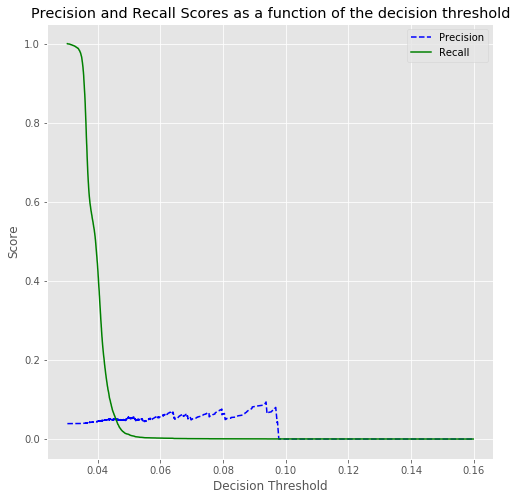

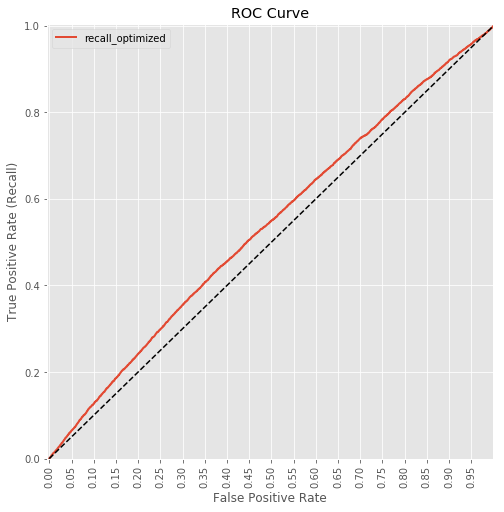

In [26]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [27]:
accuracy_score(y_test, y_new)

0.6214097666224588

### Finally you can tune your classifier of choice with GridSearchCV


In [31]:
param_grid = {
    'min_samples_split': [50, 150], 
    'n_estimators' : [100, 200],
    'max_depth': [3, 5],
    'max_features': [3, 5, 10]
}

scorers = {
    'log_score' : make_scorer(log_loss),
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [32]:
def grid_search_wrapper(clf, param_grid, scorers, refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

In [33]:
grid_search_clf = grid_search_wrapper(evaluate_clf,  param_grid, scorers, refit_score='precision_score')

Best params for precision_score
{'max_depth': 3, 'max_features': 3, 'min_samples_split': 50, 'n_estimators': 100}

Confusion matrix optimized for precision_score on the test data:
     pred_neg  pred_pos
neg    194194         0
pos      7882         0


In [35]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)

AttributeError: 'NoneType' object has no attribute 'cv_results_'